In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import re

def graph_mtree(name_file):
    colors = ['red', 'green', 'red', 'orange', 'blue', 'purple']
    cmap = plt.cm.viridis

    # Function to parse the custom data format
    def parse_data(row):
        p_match = re.search(r'p:\(([^)]+)\)', row)
        h_match = re.search(r'h:(\d+)', row)
        n_match = re.search(r'n:(\d+)', row)
        cr_match = re.search(r'cr:(\d+.\d+)', row)
        if (not cr_match):
            cr_match = re.search(r'cr:(\d+)', row)

        if not (p_match and h_match and cr_match and n_match):
            return None  # Return None if any patterns do not match
        
        p = tuple(map(float, p_match.group(1).split(',')))
        h = int(h_match.group(1))
        cr = float(cr_match.group(1))
        n = int(n_match.group(1))
        return p, h, cr, n

    # Read the CSV file
    df = pd.read_csv(name_file, header=None, delimiter=";")

    # Prepare the plot
    fig, ax = plt.subplots(figsize=(14, 14))

    # Find min and max h values for normalization
    min_h = df[0].apply(lambda x: int(re.search(r'h:(\d+)', x).group(1))).min()
    max_h = df[0].apply(lambda x: int(re.search(r'h:(\d+)', x).group(1))).max()
    norm = mcolors.Normalize(vmin=min_h, vmax=max_h)

    # Process each row in the DataFrame
    for index, row in df.iterrows():
        result = parse_data(row[0])
        if result:
            p, h, cr, n = result

            if n == 0:
                markersize = 10*(1/2)**(max_h)
                ax.plot(p[0], p[1], 'bo', markersize=markersize)
            else:
                color = colors[h % len(colors)]
                circle = plt.Circle(p, cr, color=color, fill=False)  # Draw a red circle for n!=0
                ax.add_artist(circle)

    # Set equal scaling by setting the aspect ratio to 'equal'
    ax.set_aspect('equal', adjustable='datalim')
    plt.grid(True)
    plt.show()


In [3]:
import pandas as pd
import numpy as np
from scipy.stats import norm

def read_data(file_path):
    """Reads a CSV file directly into a DataFrame with correct types."""
    # Using a more direct approach to parsing the CSV
    data = pd.read_csv(file_path, delimiter=';', header=None)
    data = data[0].str.extract(r'size:(?P<size>\d+),ios:(?P<ios>\d+)')
    data['size'] = pd.to_numeric(data['size'])
    data['ios'] = pd.to_numeric(data['ios'])
    return data

def calculate_confidence_interval(data, confidence=0.95):
    """Calculates the confidence interval for a given dataset of ios values."""
    n = len(data)
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)  # ddof=1 for sample standard deviation
    z_score = norm.ppf((1 + confidence) / 2)  # Get z-score from the normal distribution
    margin_error = z_score * (std_dev / np.sqrt(n))
    return mean, mean - margin_error, mean + margin_error

def analyze_file(file_path):
    data = read_data(file_path)
    ios_mean, ios_lower_bound, ios_upper_bound = calculate_confidence_interval(data['ios'])
    size_mean = np.mean(data['size'])
    return {
        'IOS Mean': ios_mean,
        'IOS 95% CI Lower': ios_lower_bound,
        'IOS 95% CI Upper': ios_upper_bound,
        'Size Mean': size_mean
    }

In [10]:
print("Método CP\n")
for size in [x+10 for x in range(16)]:
    file_path = f'cp/search_{size}.csv'
    results = analyze_file(file_path)
    print(f"Size Sample = 2^{size}, ", end="")
    print(f"I/OS Mean: {results['IOS Mean']:>8.2f}, I/OS 95% CI: ({results['IOS 95% CI Lower']:>12.6f}, {results['IOS 95% CI Upper']:>12.6f}), Size Mean: {results['Size Mean']:>8.2f}")


Método CP

Size Sample = 2^10, I/OS Mean:   225.21, I/OS 95% CI: (  212.672162,   237.747838), Size Mean:     1.16
Size Sample = 2^11, I/OS Mean:   279.07, I/OS 95% CI: (  264.445913,   293.694087), Size Mean:     2.37
Size Sample = 2^12, I/OS Mean:   342.00, I/OS 95% CI: (  325.679824,   358.320176), Size Mean:     5.10
Size Sample = 2^13, I/OS Mean:   466.90, I/OS 95% CI: (  450.264383,   483.535617), Size Mean:     9.97
Size Sample = 2^14, I/OS Mean:   514.99, I/OS 95% CI: (  493.886213,   536.093787), Size Mean:    19.79
Size Sample = 2^15, I/OS Mean:   616.98, I/OS 95% CI: (  593.753063,   640.206937), Size Mean:    40.34
Size Sample = 2^16, I/OS Mean:   880.02, I/OS 95% CI: (  851.445330,   908.594670), Size Mean:    80.96
Size Sample = 2^17, I/OS Mean:  1085.77, I/OS 95% CI: ( 1050.109362,  1121.430638), Size Mean:   161.72
Size Sample = 2^18, I/OS Mean:  1486.33, I/OS 95% CI: ( 1448.770660,  1523.889340), Size Mean:   323.79
Size Sample = 2^19, I/OS Mean:  2130.84, I/OS 95% CI:

In [19]:
print("Método SS\n")
for size in [x+10 for x in range(4)]:
    file_path = f'ss/search_{size}.csv'
    results = analyze_file(file_path)
    print(f"Size Sample = 2^{size}, ", end="")
    print(f"I/OS Mean: {results['IOS Mean']:>8.2f}, I/OS 95% CI: ({results['IOS 95% CI Lower']:>12.6f}, {results['IOS 95% CI Upper']:>12.6f}), Size Mean: {results['Size Mean']:>8.2f}")



Método SS

Size Sample = 2^10, I/OS Mean:   132.34, I/OS 95% CI: (  123.652938,   141.027062), Size Mean:     1.16
Size Sample = 2^11, I/OS Mean:   182.31, I/OS 95% CI: (  172.706977,   191.913023), Size Mean:     2.37
Size Sample = 2^12, I/OS Mean:   275.72, I/OS 95% CI: (  265.075287,   286.364713), Size Mean:     5.10
Size Sample = 2^13, I/OS Mean:   329.09, I/OS 95% CI: (  318.511032,   339.668968), Size Mean:     9.97


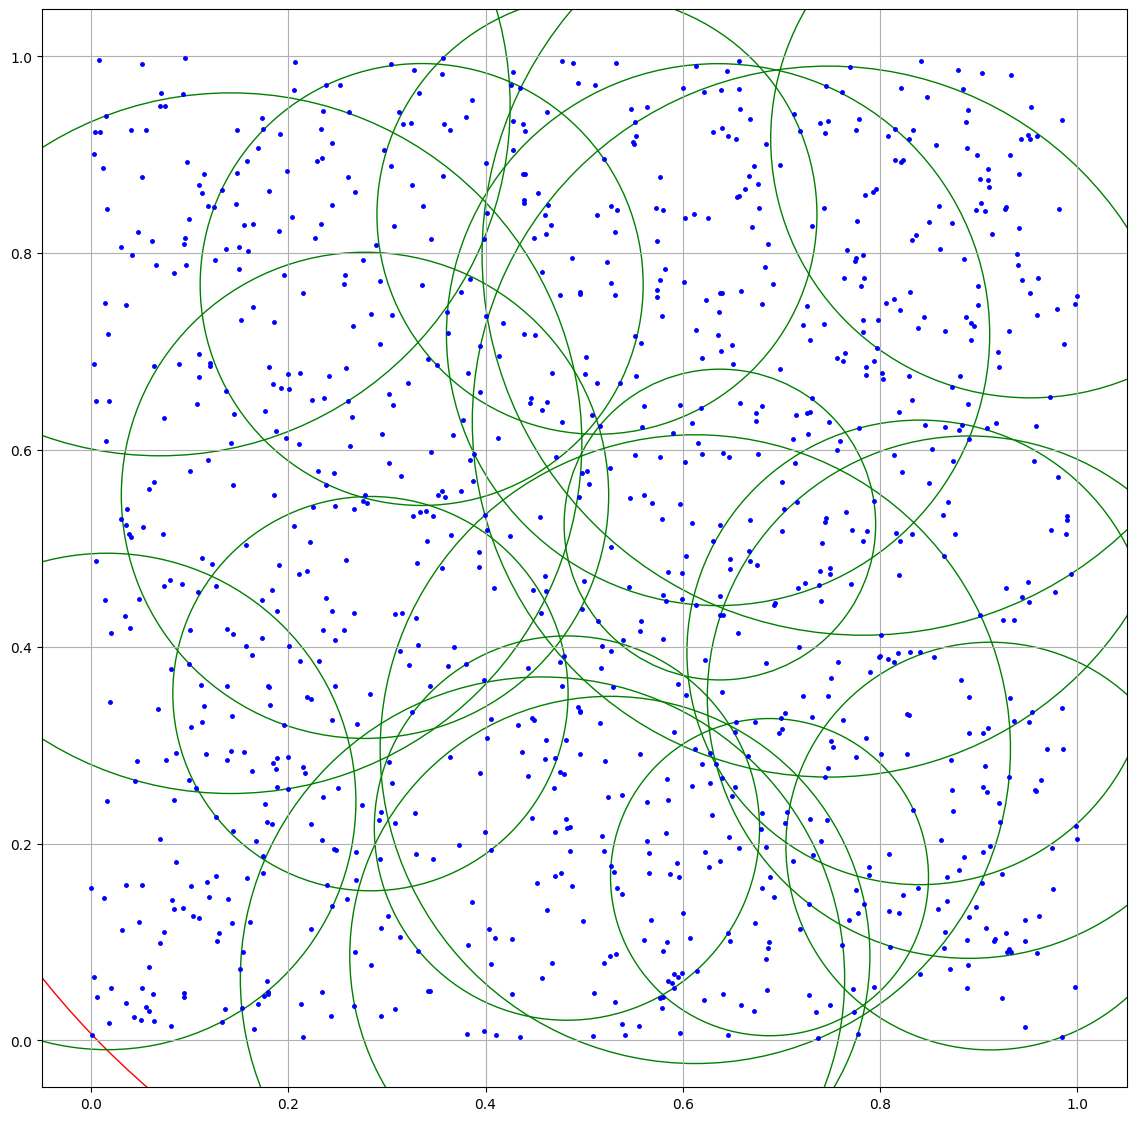

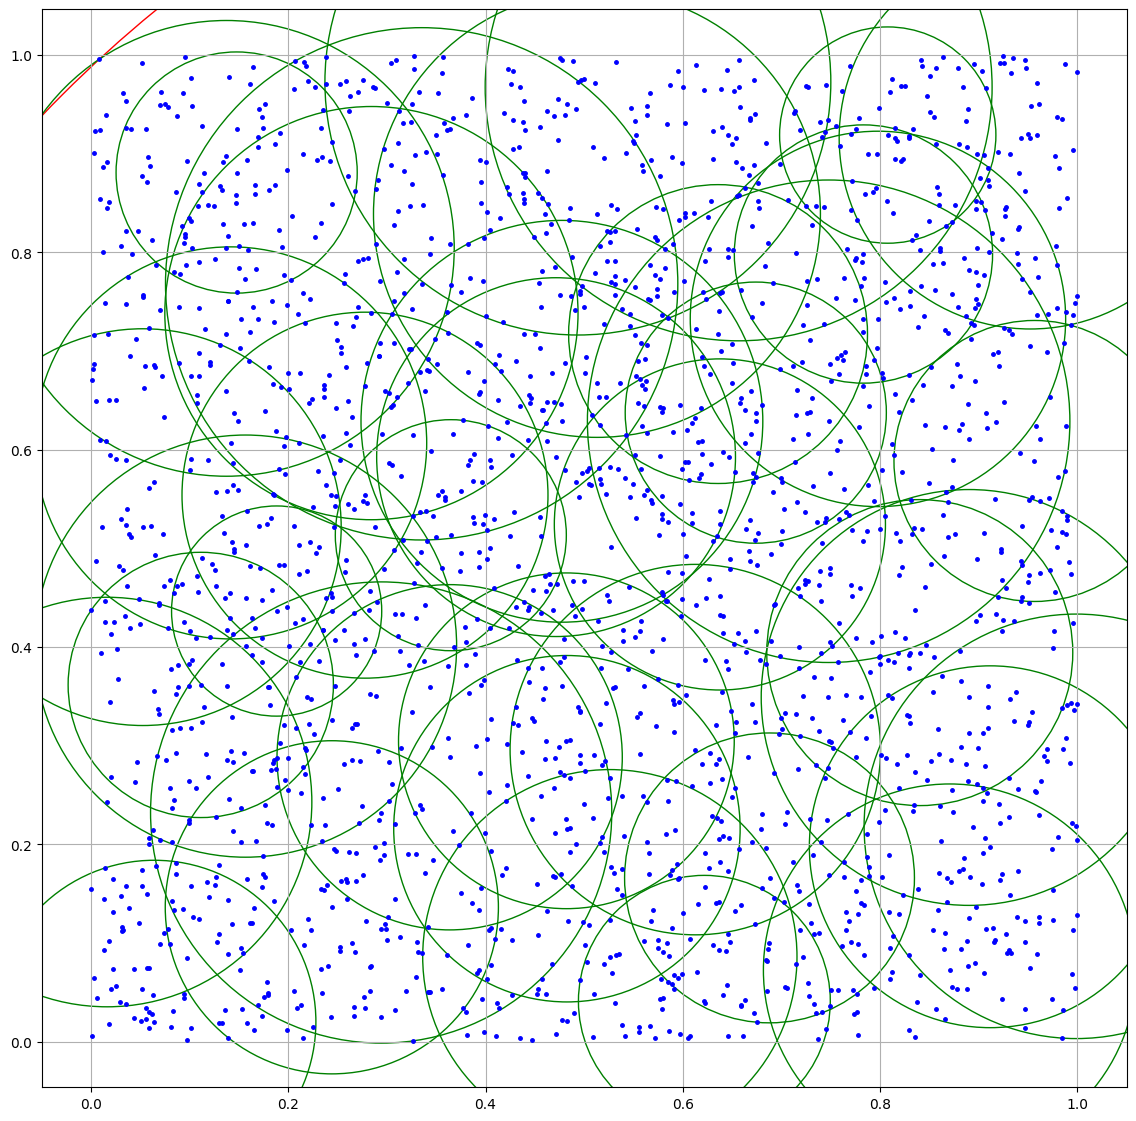

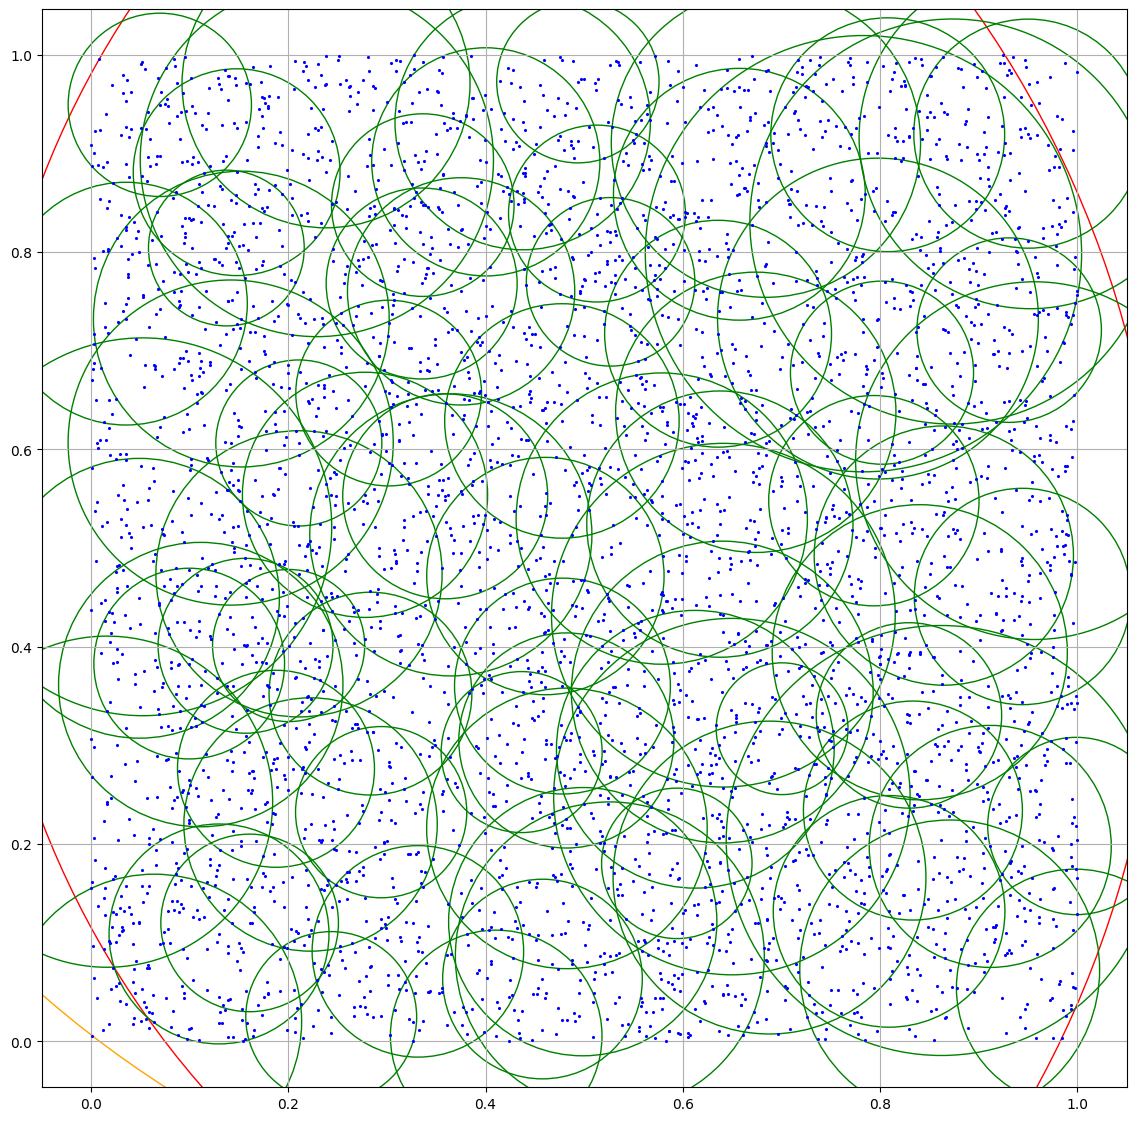

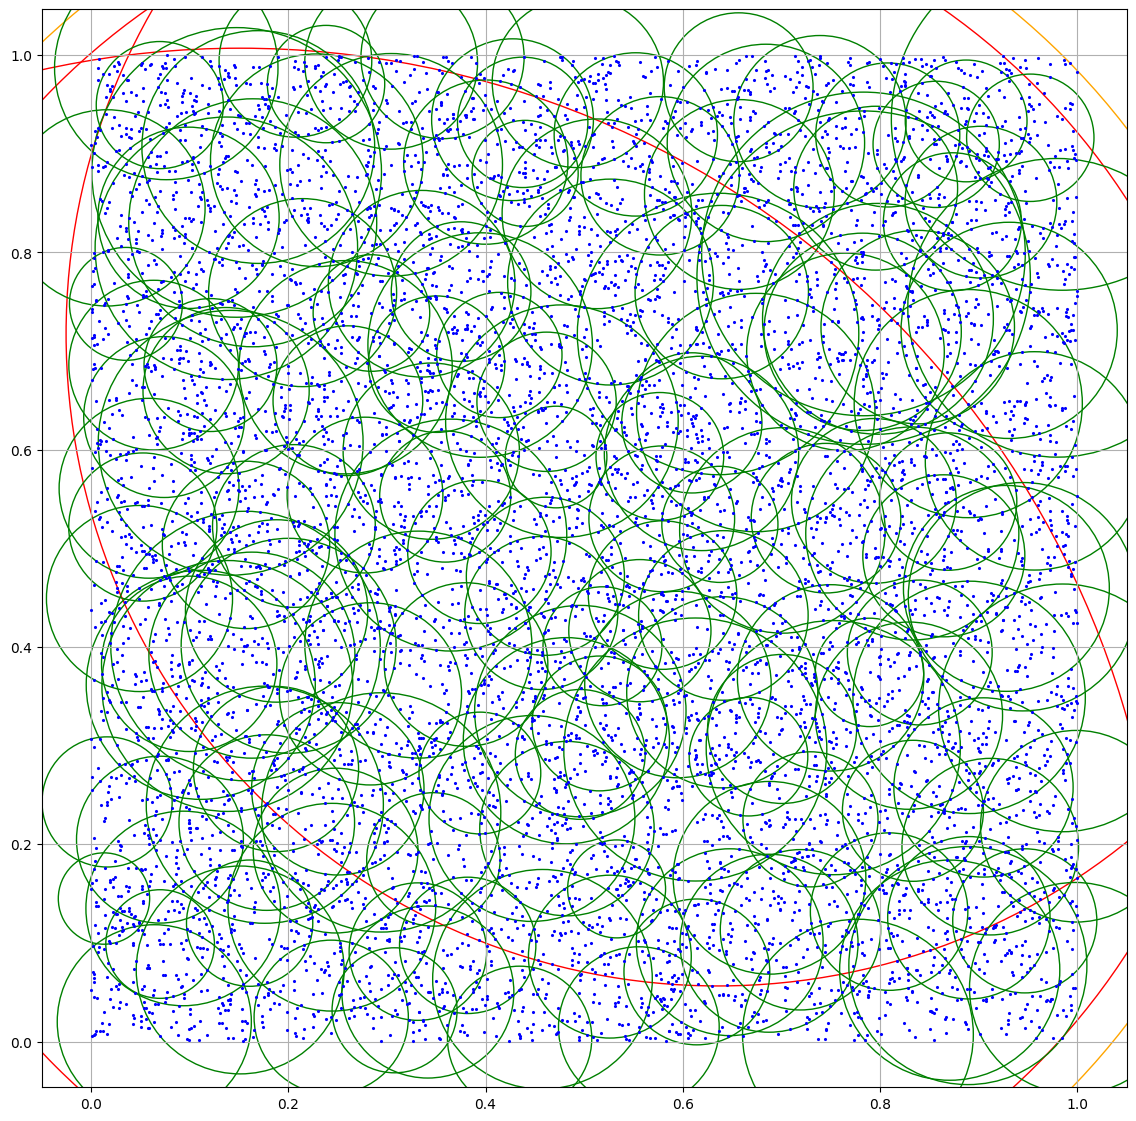

In [14]:
for size in [x+10 for x in range(4)]:
    graph_mtree(f"cp/mtree_{size}.csv")


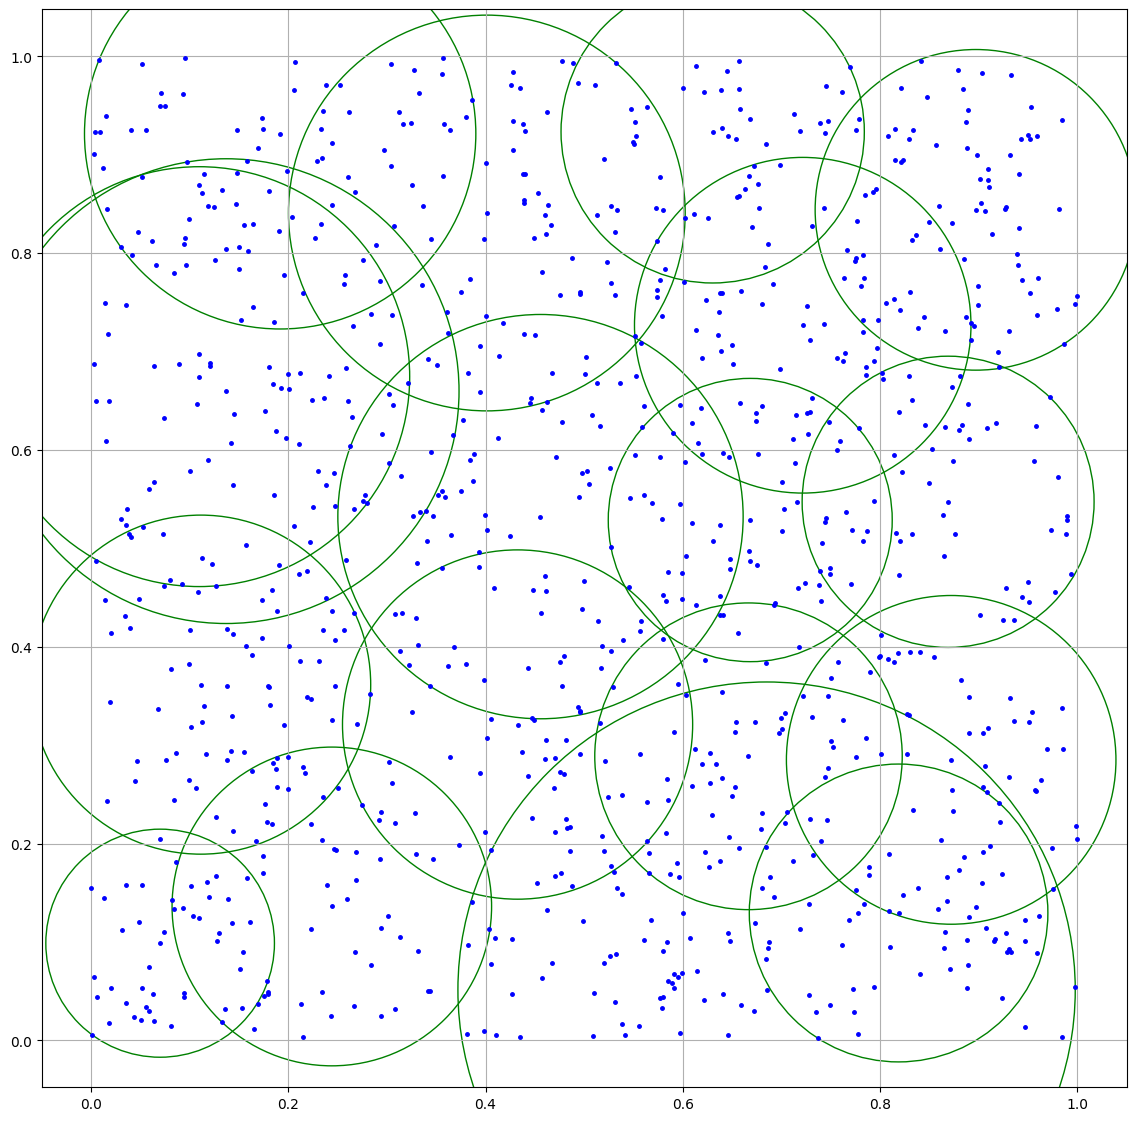

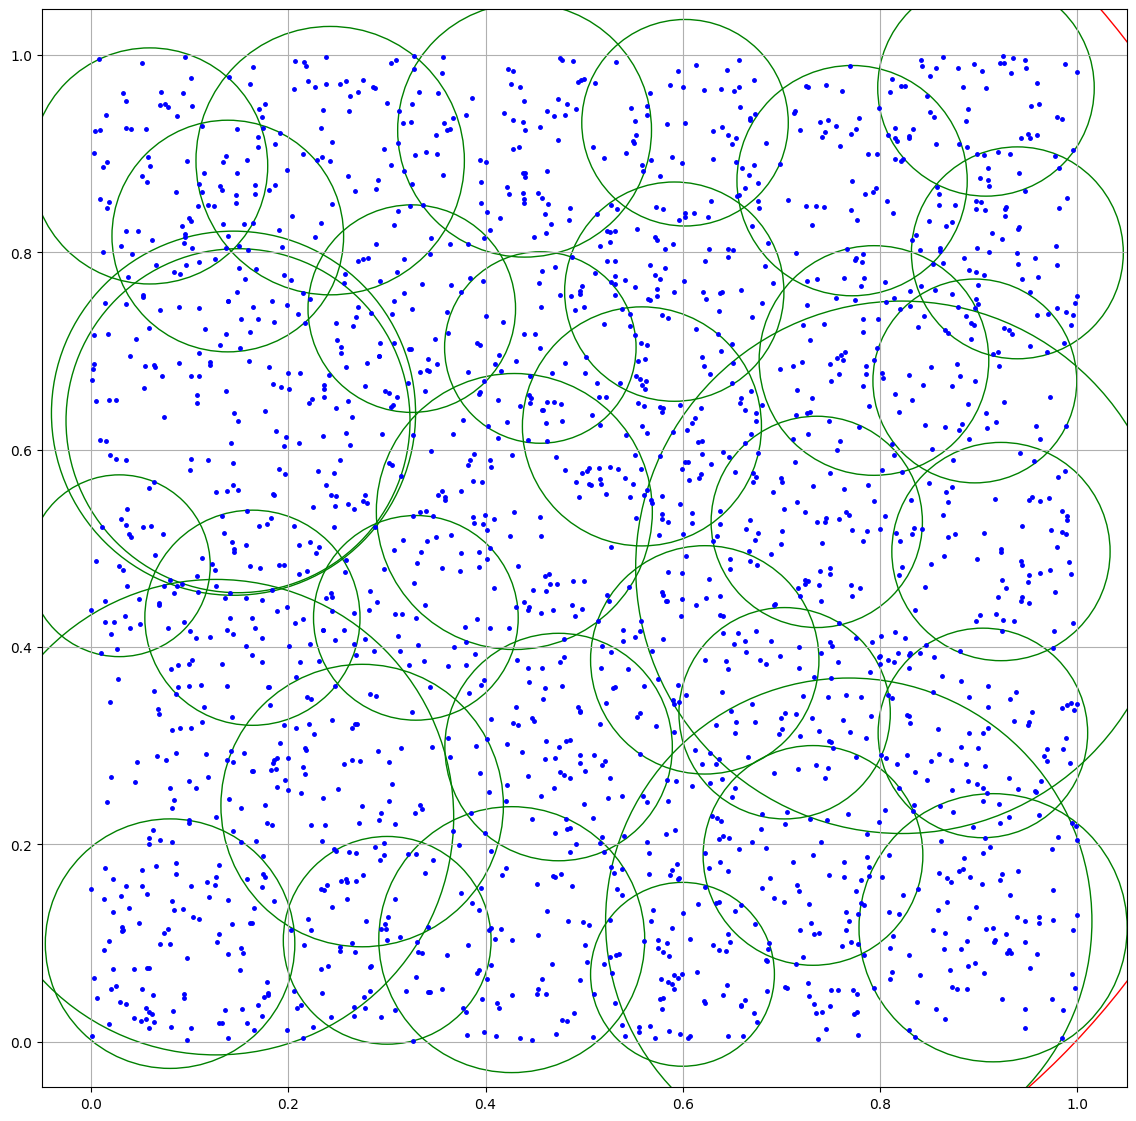

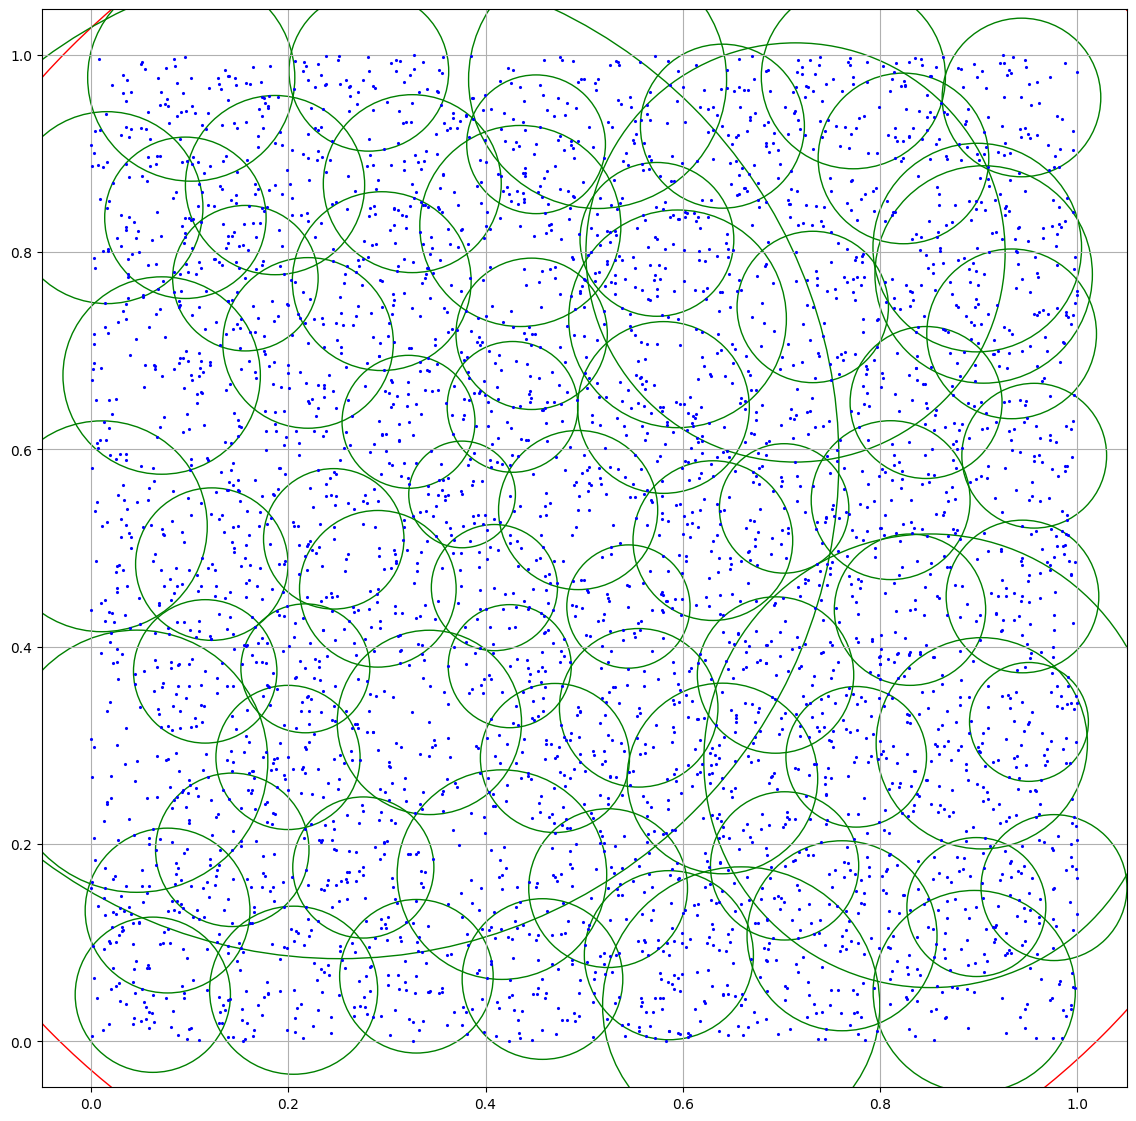

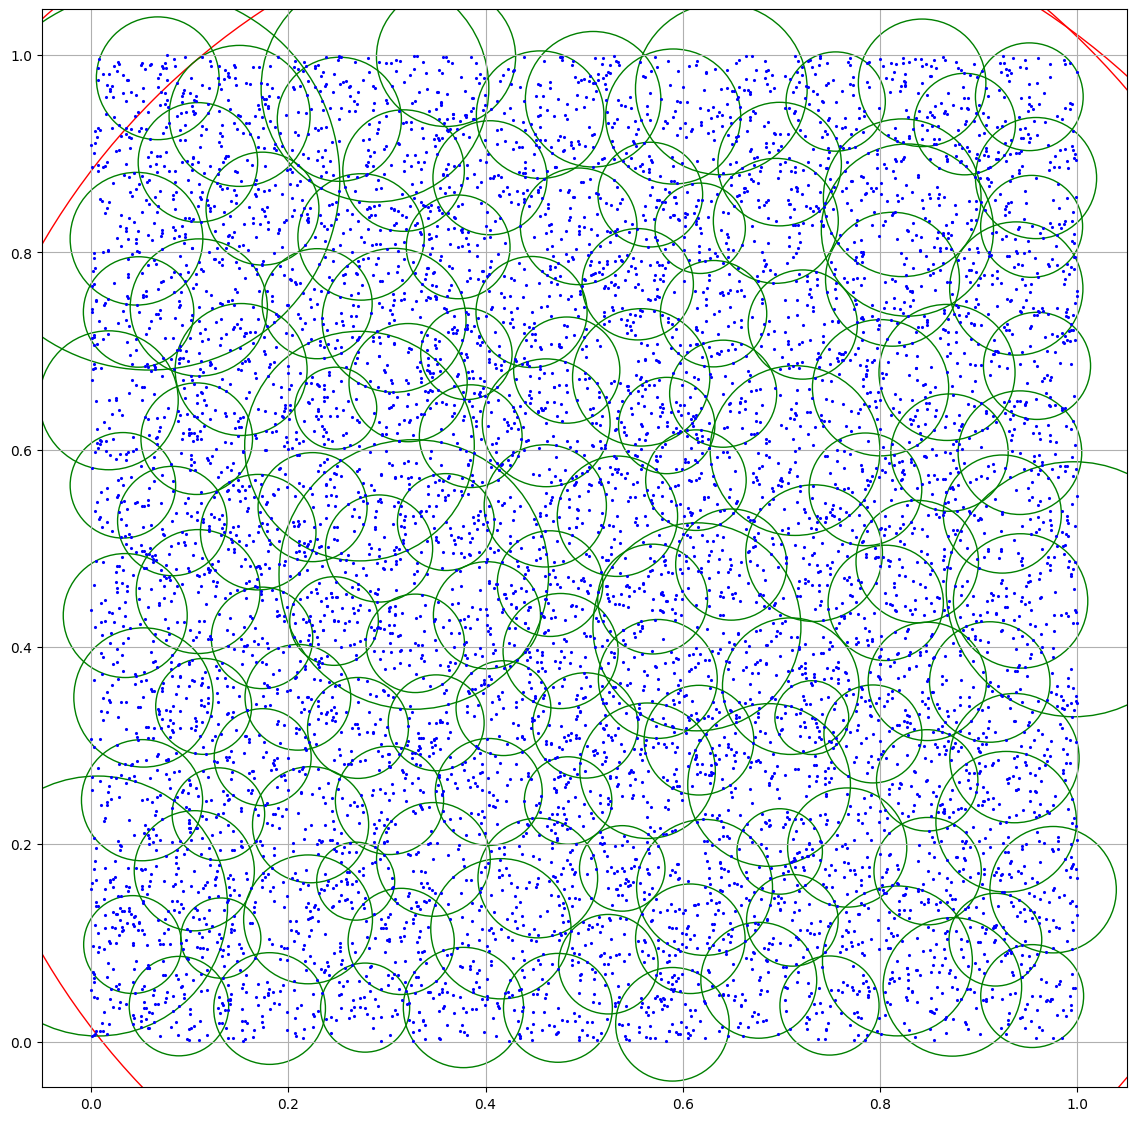

In [20]:
for size in [x+10 for x in range(4)]:
    graph_mtree(f"ss/mtree_{size}.csv");